# Wine classification

## Imports and data loading

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Reading the dataset
wine_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
wine_attributes = ['Class','Alcohol','Malic acid','Ash length','Alcalinity of ash', 'Magnesium','Total phenols','Flavanoids','Nonflavanoid phenols','Proanthocyanins','Color intensity','Hue','OD280','Proline']
# first attribute is the class identifier (1-3)
wine_df = pd.read_csv(wine_URL, names = wine_attributes)
# Rearrange dataframe and switching target to the end of list
cols = wine_df.columns.tolist() 
wine_df = wine_df[cols[1:]+cols[:1]]

In [3]:
wine_df

,Alcohol,Malic acid,Ash length,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280,Proline,Class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,3
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,3
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,3
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,3


## Defining entropy and information gain functions

Entropy is calculates using shannon's definition and information gain is the difference between entropy and split entropy

In [4]:
def Entropy(target_attribute):
    X , counts = np.unique(target_attribute, return_counts = True)
    pX = [ci/len(target_attribute) for ci in counts]
    entropy = -1*(pX@np.log2(pX))
    return entropy

In [5]:
def conditional_Entropy(Y,given): #H(Y|given)
    result =  0
    values, counts = np.unique(given, return_counts = True)
    for v , c  in zip(values,counts):
        splited_Y = [Y[i] for i in range(len(Y)) if given[i]==v]
        H = Entropy(splited_Y)
        p = c/len(given)
        result += p*H  #-1*sum(p*H)
    return result

In [6]:
def Gain(X,given):
    return Entropy(X) - conditional_Entropy(X,given)

## Defining the decision tree node data structure

In [7]:
class TNode:
    def __init__(self,name,parent=None,par_val=None):
        self.name= name
        self.parent = parent
        self.children = [] #list of TNodes, if empty =>this node is a leaf
        self.values = []
        self.par_val = par_val
        
 
    def set_values(self,v):
        self.values = list(v)

## Computing attribute with maximum gain and implementing (ID3)

In [8]:
def max_gain_node(DataFrame):
    features = list(DataFrame.columns)
    feature_dic = {features[i]:Gain(list(DataFrame[features[i]]), list(DataFrame[features[-1]])) for i in range(0,len(features)-1)}
    max_gain = max(feature_dic.values())
    index_max = list(feature_dic.values()).index(max_gain)
    winner_name = list(feature_dic.keys())[index_max]
    winner_node = TNode(winner_name)
    branches = np.unique(DataFrame[winner_name])
    winner_node.set_values(branches)
    return winner_node

def most_frequent(List): 
    return max(set(List), key = List.count)
               
def ID3(df,depth=0, root=None):
    if root==None: #Initialization
        root = max_gain_node(df)
    if root.parent:
        if len(root.values)<len(root.parent.values):
            depth =20
    depth +=1
    if depth < 20:# Maximum depth fixed to avoid over fitting and complex models             
        for att in root.values:
            child_df = df[df[root.name] == att]# Splitting dataset per specific attribute 
            child_df.drop(root.name,axis=1) # Removing the current attribute
            remaining_class_labels = list(child_df[list(child_df.columns)[-1]])
            child_labels = np.unique(remaining_class_labels) # Remaining Labels
            if len(child_labels)>1:# not leaf-> recurse
                next_max_gain = max_gain_node(child_df)
                next_max_gain.parent = root
                next_max_gain.par_val=att
                root.children.append(next_max_gain)
                ID3(child_df,depth, root=next_max_gain)
        
            else:# else if leaf node
                leaf = TNode(child_labels[0])
                leaf.parent = root
                leaf.par_val = att
                root.children.append(leaf)
                depth =1
    else: # Edge case for deep tree
        common_label = most_frequent(list(df[list(df.columns)[-1]]))
        leaf = TNode(common_label)
        root.children = []
        root.values = []
        leaf.parent = root.parent
        leaf.par_val = root.par_val
        root.parent.children.remove(root)
        root.parent.children.append(leaf)
        depth = 1

    return root
                    
# Visualizing decision tree
def rep_tree(root,depth=-1):
    if len(root.values)==0:#leaf
        print('|',root.name,'|')
        return
    else:
        depth +=1
        for child in root.children:
            print(depth*'\t',root.name,'=',child.par_val,'->')
            rep_tree(child,depth)

## Prediction by ID3 function and binary confusion definition

In [9]:
# run sample through a decision tree
def wine_prediction(root,keys,test,labels=None):
    try:
        if len(root.children)==0:
            return root.name
        elif root.values[0] == test[keys.index(root.name)]:
            return wine_prediction(root.children[0],keys,test,labels)
        else:# root.values[1] == test[keys.index(root.name)]:
            return wine_prediction(root.children[1],keys,test,labels)
    except:
        print('e', end =' ' )
        return labels[np.random.randint(0,high=len(labels))]

       
def binary_confusion(GT,y_predicted):
    TP,FP,TN,FN = 0,0,0,0
    for index in range(len(GT)):
        if GT[index]=='positive':
            if y_predicted[index]=='positive':
                TP +=1
            else:
                FP +=1
        else:
            if y_predicted[index]=='negative':
                TN +=1
            else:
                FN +=1     
    return[[TP,FP],[FN,TN]]

## Data split and confusion matrix

Confusion matrix is a table used to gauge performance of a binary classifier based on true/false positives and negatives

In [10]:
# binary split using a threshold 
for column in wine_df.columns:
    if column == 'Class':
        break
    att = wine_df[column].to_list()
    threshhold = np.median(att)
    binary_col = [True if a>threshhold else False for a in att]
    wine_df[column] = binary_col
     
def confusion_mat(GT,predicted,labels):
    count11,count12,count13 = 0,0,0
    count21,count22,count23 = 0,0,0
    count31,count32,count33 = 0,0,0

    for i in range(len(GT)):
        if GT[i]==labels[0]:
            if predicted[i] ==labels[0]:
                count11 +=1
            elif predicted[i] ==labels[1]:
                count12 +=1
            elif predicted[i] ==labels[2]:
                count13 +=1
        elif GT[i]==labels[1]:
            if predicted[i] ==labels[0]:
                count21 +=1
            elif predicted[i] ==labels[1]:
                count22 +=1
            elif predicted[i] ==labels[2]:
                count23 +=1
        elif GT[i]==labels[2]:
            if predicted[i] ==labels[0]:
                count31 +=1
            elif predicted[i] ==labels[1]:
                count32 +=1
            elif predicted[i] ==labels[2]:
                count33 +=1
    return [[count11,count12,count13],\
            [count21,count22,count23],[count31,count32,count33]]

## Seeding and sampling to ensure random data and running ID3

In [11]:
wine_Accuracy,wine_confusion = [] ,[]  
d = int(len(wine_df)/10)+1
wine_labels  =np.unique(list(wine_df.Class))
root = None
for times in range(0,10):
    Dataset = wine_df.sample(frac=1,random_state=4122020)
    #shuffling dataset and random sampling with seed
    Folds = [Dataset[:d],\
             Dataset[d:2*d],Dataset[2*d:3*d],Dataset[3*d:4*d],\
             Dataset[4*d:5*d],Dataset[5*d:6*d],Dataset[6*d:7*d],\
             Dataset[7*d:8*d],Dataset[8*d:9*d],\
             Dataset[9*d:]
             ]
        #10 Folds cross-validation
        #Train ID3 based on 90% data and validate result on 10%
    for i in np.arange(10):
        test_df = Folds[i]
        train_df = pd.concat([Folds[i-9],Folds[i-8],Folds[i-7],\
                              Folds[i-6],Folds[i-5],Folds[i-4],\
                              Folds[i-3],Folds[i-2],Folds[i-1]])
        root = ID3(train_df)
        y_true = test_df[test_df.columns[-1]].to_list()
        y_wine_pred = []
        for r in range(0,len(test_df)):
            test = test_df.iloc[r,:].to_list()
            prediction = wine_prediction(root,list(test_df.columns),test,\
                                   labels=wine_labels)
            y_wine_pred.append(prediction)

        conf = confusion_mat(y_true,y_wine_pred,wine_labels)
        if len(y_true)>0:
            wine_confusion.append(conf)
            wine_Accuracy.append((conf[0][0]+conf[1][1]+conf[2][2])/len(y_true))        

## Evaluating prediction accuracy for ID3 model

Wine prediction:
Mean(Accuracy)=%91.53, Var(Accuracy)= 0.0046

Confusion Matrix:


<ipython-input-12-d7621b4f3fea>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
<ipython-input-12-d7621b4f3fea>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


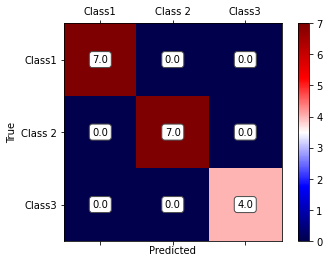

In [12]:
import matplotlib.pyplot as plt
print('Wine prediction:')
print('Mean(Accuracy)=%{:.2f}, Var(Accuracy)= {:.4f}'.format(np.mean(wine_Accuracy)*100,np.var(wine_Accuracy)))
print('\nConfusion Matrix:')
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(wine_confusion[np.argmax(wine_Accuracy)], cmap='seismic')
for (i, j), z in np.ndenumerate(wine_confusion[np.argmax(wine_Accuracy)]):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
fig.colorbar(cax)
alpha = ['Class1', 'Class 2', 'Class3']
plt.xlabel('Predicted')
plt.ylabel('True')
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
plt.show()

In [13]:
from sklearn.metrics import classification_report

In [14]:
print(classification_report(y_true,y_wine_pred,digits = 3))

              precision    recall  f1-score   support

           1      1.000     1.000     1.000         4
           2      1.000     0.714     0.833         7
           3      0.714     1.000     0.833         5

    accuracy                          0.875        16
   macro avg      0.905     0.905     0.889        16
weighted avg      0.911     0.875     0.875        16

